## Importing necessary libraries

In [1]:
import os
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder,MultiLabelBinarizer,label_binarize
from keras.layers import concatenate,Input, Conv2D, MaxPooling2D, Flatten, Dense, Concatenate,Dropout,Softmax,BatchNormalization,Activation,DepthwiseConv2D ,ReLU,Add,GlobalAveragePooling2D,Multiply,Average
from keras.models import Model
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc, precision_recall_curve, average_precision_score
from sklearn.metrics import classification_report, confusion_matrix
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing import image
from keras.utils import load_img,img_to_array,array_to_img
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping
import numpy as np
import cv2
import seaborn as sns
import keras
import matplotlib.cm as cm
from keras.callbacks import ReduceLROnPlateau,LearningRateScheduler

### Extracting files from zip

## Reading train labels

In [2]:
df_train = pd.read_csv('Fall/train_labels.csv', index_col='images')
df_train

,labels
images,
fall-02-cam1-rgb-001.jpg,0
fall-02-cam1-rgb-002.jpg,0
fall-02-cam1-rgb-003.jpg,0
fall-02-cam1-rgb-004.jpg,0
fall-02-cam1-rgb-005.jpg,0
...,...
fall-11-cam1-rgb-126.jpg,1
fall-11-cam1-rgb-127.jpg,1
fall-11-cam1-rgb-128.jpg,1


## Reading test labels

In [3]:
test_df = pd.read_csv('Fall/test_labels.csv', index_col='images')
test_df

,labels
images,
fall-03-cam1-rgb-077.jpg,0
fall-03-cam1-rgb-093.jpg,0
fall-03-cam1-rgb-178.jpg,1
fall-03-cam1-rgb-196.jpg,1
fall-04-cam1-rgb-005.jpg,0
fall-04-cam1-rgb-042.jpg,1
fall-04-cam1-rgb-057.jpg,1
fall-17-cam1-rgb-068.jpg,1
fall-17-cam1-rgb-094.jpg,1


In [4]:
# reading train and test images from the folder and stacking them while keep tracking of corresponding labels
dataset_folder = 'Fall'
train_images = []
train_labels = []
test_images = []
test_labels = []

for folder in os.listdir(dataset_folder):
    folder_path = os.path.join(dataset_folder, folder)
    if folder == 'train_images':
        for file in os.listdir(folder_path):
            if file.endswith('jpg'):
                img_path = os.path.join(folder_path, file)
                img = cv2.imread(img_path)
                train_images.append(img)
                train_labels.append(df_train.loc[file, 'labels'])
    
    elif folder == 'test_images':
        for file in os.listdir(folder_path):
            if file.endswith('jpg'):
                img_path = os.path.join(folder_path, file)
                img = cv2.imread(img_path)
                test_images.append(img)
                test_labels.append(test_df.loc[file, 'labels'])
    else:
        pass
            
train_images = np.array(train_images)
train_labels = np.array(train_labels)
test_images = np.array(test_images)
test_labels = np.array(test_labels)
print('Shape of stacked train images:', train_images.shape)
print('Shape of train labels:', train_labels.shape)
print('Shape of stacked test images:', test_images.shape)
print('Shape of test labels:', test_labels.shape)

Shape of stacked train images: (240, 96, 96, 3)
Shape of train labels: (240,)
Shape of stacked test images: (12, 96, 96, 3)
Shape of test labels: (12,)


## Visualizing some images together with their label to have an idea about our data

In [5]:
# Function to convert binary label into text
def get_label(num):
    if num == 0:
        return 'NOT FALL'
    if num == 1:
        return 'FALL'
    else:
        return -1

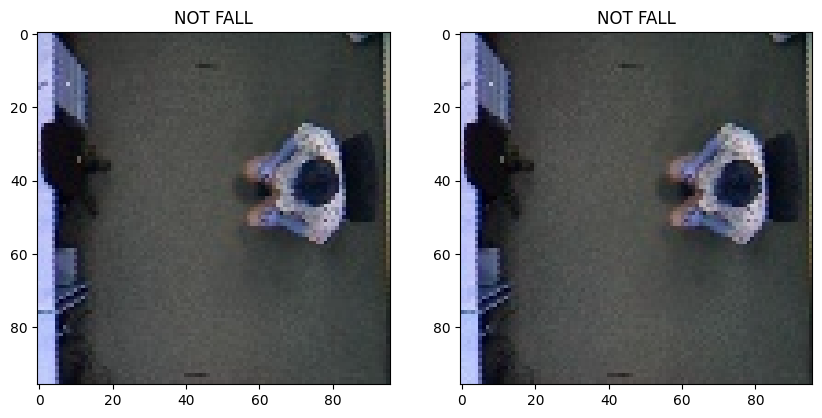

In [6]:
fig, axes = plt.subplots(1, 2, figsize=(10, 8), squeeze=False)
axes[0][0].imshow(train_images[2])
axes[0][0].set_title(get_label(train_labels[2]))

axes[0][1].imshow(train_images[3])
axes[0][1].set_title(get_label(train_labels[3]));

## Splitting our data into train and validation sets, building and training our model

In [7]:
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(train_images, train_labels, stratify=train_labels, test_size=0.2)
input_shape = (96,96,3)
num_classes = 1

In [53]:
class Spatial_Attention(tf.keras.layers.Layer):
    def __init__(self, num_filter):
        super(Spatial_Attention, self).__init__()
        self.conv1 = Conv2D(num_filter // 8, kernel_size=1, strides=1, padding='valid')
        self.conv2 = Conv2D(num_filter // 8, kernel_size=1, strides=1, padding='valid')
        self.conv3 = Conv2D(num_filter, kernel_size=1, strides=1, padding='valid')
    def call(self, inputs):
        x = self.conv1(inputs)
        x = tf.nn.relu(x)
        x = self.conv2(x)
        x = tf.nn.relu(x)
        x = self.conv3(x)
        attention_maps = tf.nn.sigmoid(x)
        attention_maps = tf.keras.layers.multiply([inputs, attention_maps])
        return attention_maps

In [54]:
class Channel_Attention(tf.keras.layers.Layer):
    def __init__(self, channels):
        super(Channel_Attention, self).__init__()
        self.channels=channels
        self.conv1= Conv2D(self.channels, kernel_size=1, strides=1, padding='valid')
        self.conv2= Conv2D(self.channels, kernel_size=1, strides=1, padding='valid')

    def call(self, inputs):
        x = self.conv1(inputs)
        x = tf.nn.relu(x)
        x = self.conv2(x)
        x = tf.nn.softmax(x, axis=-1) 
        return x

In [55]:
def residual_block_with_spatial_attention(inputs, num_filter):
    x = Conv2D(num_filter, kernel_size=(2, 2), padding='same')(inputs)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Dropout(0.5)(x)
    x = Conv2D(num_filter, kernel_size=(2, 2), padding='same')(x)
    x = BatchNormalization()(x)
    if inputs.shape[-1] != num_filter:
        shortcut = Conv2D(num_filter, kernel_size=(2, 2), padding='same')(inputs)
        shortcut = BatchNormalization()(shortcut)
    else:
        shortcut = inputs
    attention = Spatial_Attention(num_filter)(x)
    x = Multiply()([attention, x])
    x = Add()([x, shortcut])
    x = Activation('relu')(x)
    return x

In [56]:
def residual_block_with_channel_attention(inputs, num_filter):
    x = Conv2D(num_filter, kernel_size=(2, 2), padding='same')(inputs)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Dropout(0.5)(x)   
    x = Conv2D(num_filter, kernel_size=(2, 2), padding='same')(x)
    x = BatchNormalization()(x)
    if inputs.shape[-1] != num_filter:
        shortcut = Conv2D(num_filter, kernel_size=(2, 2), padding='same')(inputs)
        shortcut = BatchNormalization()(shortcut)
    else:
        shortcut = inputs
    attention = Channel_Attention(num_filter)(x)
    x = Multiply()([attention, x])
    x = Add()([x, shortcut])
    x = Activation('relu')(x)
    return x

In [57]:
# Modify the ResNet model to include the attention mechanism
def ResNet_with_channel_spatial_attention(input_shape, num_classes):
    inputs = Input(shape=input_shape)
    x = Conv2D(32, kernel_size=(2, 2), padding='same', kernel_regularizer=tf.keras.regularizers.l2(0.01))(inputs)
    x = BatchNormalization()(x)
    x = MaxPooling2D(2, 2)(x)
    x = Activation('relu')(x)   
    x = residual_block_with_channel_attention(x, 32)
    x = residual_block_with_spatial_attention(x, 64)
    x = GlobalAveragePooling2D()(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.5)(x)   
    outputs = Dense(num_classes, activation='sigmoid')(x)

    model = Model(inputs=inputs, outputs=outputs)
    return model

In [58]:
from tensorflow.keras.regularizers import l2
def Kai_cnn(input_shape, num_classes):
    inputs = Input(shape=input_shape)
    # Convolutional layers
    conv1 = Conv2D(32, kernel_size=(3, 3), activation='relu', padding="same")(inputs)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    conv2 = Conv2D(64, kernel_size=(3, 3), activation='relu', padding="same")(pool1)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    conv3 = Conv2D(128, kernel_size=(3, 3), activation='relu', padding="same")(pool2)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    # Attention layer
    attention = Channel_Attention(channels=128)(pool3)
    # Apply attention to the feature map
    attention_maps = tf.multiply(pool3, attention)
    concatenate_maps = Concatenate()([pool3, attention_maps])
    # Regularization
    regularization = Conv2D(128, kernel_size=(1, 1), activation='relu', padding='same')(concatenate_maps)
    flatten = Flatten()(regularization)
    fc1 = Dense(256, activation='relu')(flatten)
    dropout1 = Dropout(0.2)(fc1)
    output = Dense(num_classes, activation='sigmoid')(dropout1)
    model = Model(inputs=inputs, outputs=output)
    return model

In [59]:
input_shape = (96, 96, 3)
num_classes = 1

def create_ensemble_model(input_shape):
    input_layer = Input(shape=input_shape)
    model1 = ResNet_with_channel_spatial_attention(input_shape,num_classes)(input_layer)
    model2 = Kai_cnn(input_shape,num_classes)(input_layer)
    merged = concatenate([model1, model2])
    dense = Dense(128,activation="relu")(merged)
    output_layer = Dense(num_classes, activation='sigmoid')(dense)
    model = Model(inputs=input_layer, outputs=output_layer)
    return model

model1 = ResNet_with_channel_spatial_attention(input_shape, num_classes)
model2 = Kai_cnn(input_shape, num_classes)
model = create_ensemble_model(input_shape)


In [60]:
model1.summary()

Model: "model_44"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_7 (InputLayer)           [(None, 96, 96, 3)]  0           []                               
                                                                                                  
 conv2d_31 (Conv2D)             (None, 96, 96, 32)   416         ['input_7[0][0]']                
                                                                                                  
 batch_normalization_8 (BatchNo  (None, 96, 96, 32)  128         ['conv2d_31[0][0]']              
 rmalization)                                                                                     
                                                                                                  
 max_pooling2d_13 (MaxPooling2D  (None, 48, 48, 32)  0           ['batch_normalization_8[0]

In [61]:
model2.summary()

Model: "model_45"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_8 (InputLayer)           [(None, 96, 96, 3)]  0           []                               
                                                                                                  
 conv2d_42 (Conv2D)             (None, 96, 96, 32)   896         ['input_8[0][0]']                
                                                                                                  
 max_pooling2d_14 (MaxPooling2D  (None, 48, 48, 32)  0           ['conv2d_42[0][0]']              
 )                                                                                                
                                                                                                  
 conv2d_43 (Conv2D)             (None, 48, 48, 64)   18496       ['max_pooling2d_14[0][0]']

In [17]:
model.summary(expand_nested=True)

In [18]:
def conv2d(filters: int, name):
    return Conv2D(filters=filters, kernel_size=(3, 3), padding='same', kernel_regularizer=l2(0.), bias_regularizer=l2(0.), name=name)

### Visualizing out CNN Arhitecture with visualkeras Library

In [20]:
model.compile(optimizer=tf.keras.optimizers.Adam(lr=0.001), loss='binary_crossentropy', metrics=['accuracy'])
history = model.fit(X_train,y_train, epochs = 6, validation_data = (X_val, y_val))

Epoch 1/6


C:\Users\AW\anaconda3\envs\myenv\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


6/6 [==============================] - 3s 86ms/step - loss: 2.0739 - accuracy: 0.7552 - val_loss: 0.4095 - val_accuracy: 0.7708
Epoch 2/6
6/6 [==============================] - 0s 12ms/step - loss: 0.2296 - accuracy: 0.9010 - val_loss: 0.1198 - val_accuracy: 0.9583
Epoch 3/6
6/6 [==============================] - 0s 12ms/step - loss: 0.0943 - accuracy: 0.9688 - val_loss: 0.0348 - val_accuracy: 1.0000
Epoch 4/6
6/6 [==============================] - 0s 13ms/step - loss: 0.0299 - accuracy: 0.9948 - val_loss: 0.0099 - val_accuracy: 1.0000
Epoch 5/6
6/6 [==============================] - 0s 13ms/step - loss: 0.0267 - accuracy: 0.9896 - val_loss: 0.0153 - val_accuracy: 1.0000
Epoch 6/6
6/6 [==============================] - 0s 14ms/step - loss: 0.0164 - accuracy: 1.0000 - val_loss: 0.0041 - val_accuracy: 1.0000


## Accuracy/Loss vs Epochs

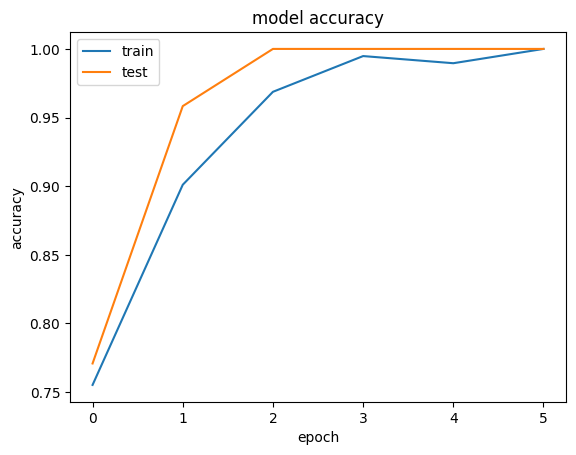

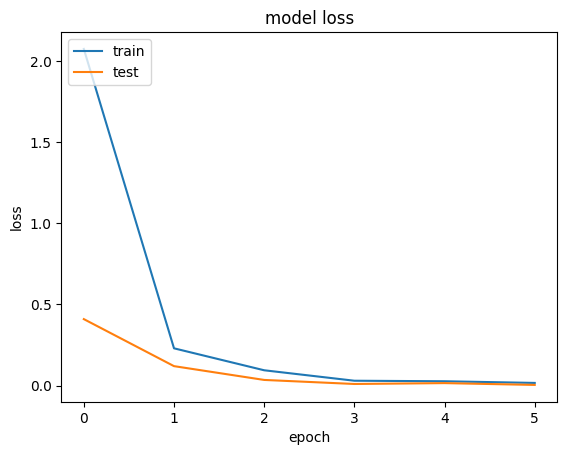

Weights saved.


In [21]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

model.save('model.h5')
print('Weights saved.')

In [22]:
# import numpy as np
# from sklearn.metrics import precision_recall_curve, roc_curve, auc
# precision, recall, thresholds_pr = precision_recall_curve(test_labels, y_pred)
# fpr, tpr, thresholds_roc = roc_curve(test_labels, y_pred)
# auc_pr = auc(recall, precision)
# auc_roc = auc(fpr, tpr)


1/1 - 0s - loss: 0.0345 - accuracy: 1.0000 - 108ms/epoch - 108ms/step
Test accuracy: 1.0
1/1 [==============================] - 0s 116ms/step
Precision: 1.0
Recall: 1.0


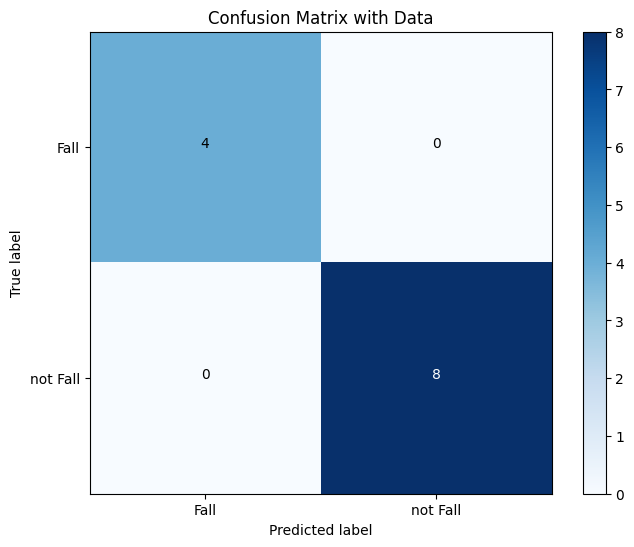

In [23]:
import tensorflow as tf
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, precision_recall_curve, roc_curve, auc
import matplotlib.pyplot as plt
classes = ["Fall","not Fall"]

test_loss, test_accuracy = model.evaluate(test_images, test_labels, verbose=2)

print(f"Test accuracy: {test_accuracy}")


y_pred = model.predict(test_images)

y_pred_classes = (y_pred > 0.5).astype(int)

precision = precision_score(test_labels, y_pred_classes, average='binary')
recall = recall_score(test_labels, y_pred_classes, average='binary')

print(f"Precision: {precision}")
print(f"Recall: {recall}")

conf_matrix = confusion_matrix(test_labels, y_pred_classes)

# 绘制带有数据的混淆矩阵
plt.figure(figsize=(8, 6))
plt.imshow(conf_matrix, cmap=plt.cm.Blues, interpolation='nearest')
plt.title('Confusion Matrix with Data')
plt.colorbar()
plt.xticks(np.arange(2), ["Fall", "not Fall"])
plt.yticks(np.arange(2), ["Fall", "not Fall"])
plt.xlabel('Predicted label')
plt.ylabel('True label')

# 添加混淆矩阵中的计数数据
thresh = conf_matrix.max() / 2.0
for i in range(2):
    for j in range(2):
        plt.text(j, i, format(conf_matrix[i, j], 'd'),
                 horizontalalignment="center",
                 color="white" if conf_matrix[i, j] > thresh else "black")

plt.show()

# 其余的代码保持不变


In [24]:


from sklearn.metrics import confusion_matrix, recall_score, accuracy_score

# Calculate confusion matrix
conf_matrix = confusion_matrix(test_labels, y_pred_classes)

# Extract true positive (TP), false positive (FP), true negative (TN), and false negative (FN) from the confusion matrix
TN, FP, FN, TP = conf_matrix.ravel()

# Sensitivity, or recall, is the TPR (True Positive Rate)
sensitivity = recall_score(test_labels, y_pred_classes, average='binary')

# Specificity is the TNR (True Negative Rate), which is TN / (TN + FP)
specificity = TN / (TN + FP)

print(f"Sensitivity (Recall): {sensitivity}")
print(f"Specificity: {specificity}")



Sensitivity (Recall): 1.0
Specificity: 1.0


Confusion Matrix:
[[4 0]
 [0 8]]


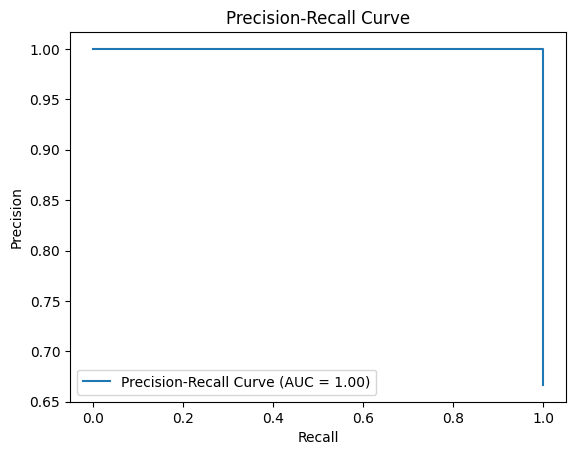

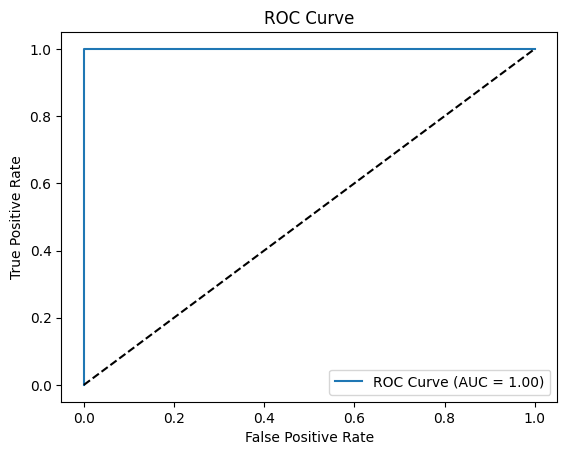

Classification Report:
              precision    recall  f1-score   support

        Fall       1.00      1.00      1.00         4
    not Fall       1.00      1.00      1.00         8

    accuracy                           1.00        12
   macro avg       1.00      1.00      1.00        12
weighted avg       1.00      1.00      1.00        12

Weights saved.


In [25]:
print(f"Confusion Matrix:\n{conf_matrix}")

precision, recall, thresholds_pr = precision_recall_curve(test_labels, y_pred)

auc_pr = auc(recall, precision)

plt.plot(recall, precision, label=f'Precision-Recall Curve (AUC = {auc_pr:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.show()

fpr, tpr, thresholds_roc = roc_curve(test_labels, y_pred)

auc_roc = auc(fpr, tpr)

plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {auc_roc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

from sklearn.metrics import classification_report
report = classification_report(test_labels, y_pred_classes,target_names = classes)
print("Classification Report:")
print(report)

model.save('model.h5')
print('Weights saved.')

## Testing our model

In [26]:
predicted_labels = (model.predict(test_images) >= 0.5).astype('int64').flatten()

1/1 [==============================] - 0s 19ms/step


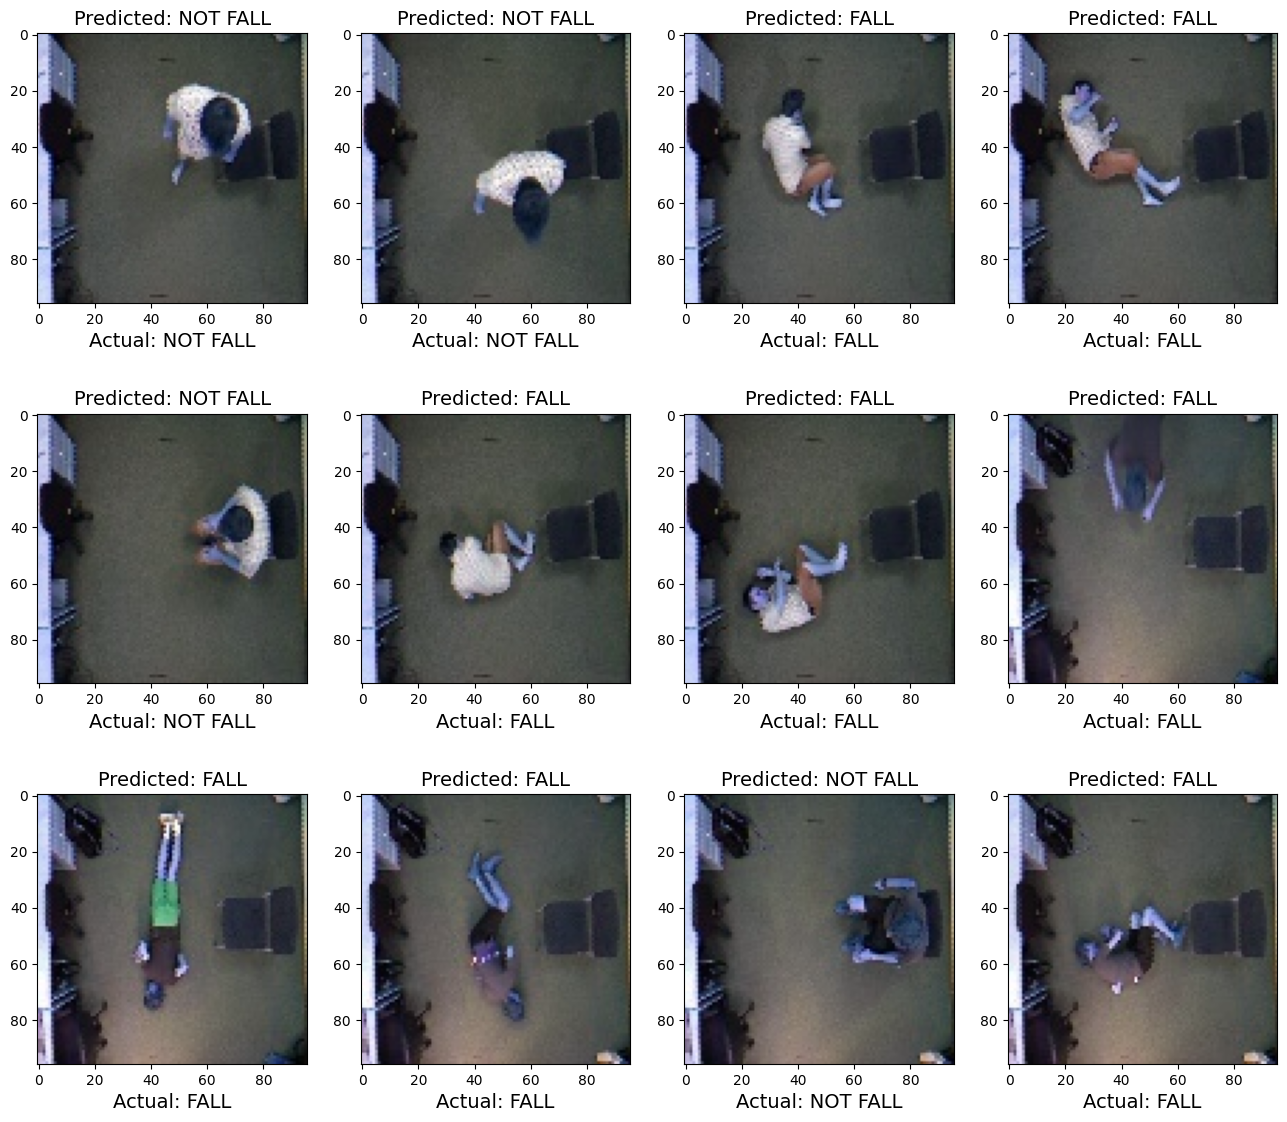

In [27]:
# visualizing our results
row = 3
col = 4
fig, axes = plt.subplots(row, col, figsize=(16, 14))
c = 0
for i in range(row):
    for j in range(col):
        axes[i][j].imshow(test_images[c])
        axes[i][j].set_title(f'Predicted: {get_label(predicted_labels[c])}', fontsize=14)
        axes[i][j].set_xlabel(f'Actual: {get_label(test_labels[c])}', fontsize=14)
        c += 1

1/1 [==============================] - 0s 20ms/step


C:\Users\AW\AppData\Local\Temp\ipykernel_16844\727739497.py:62: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  jet = cm.get_cmap("jet")


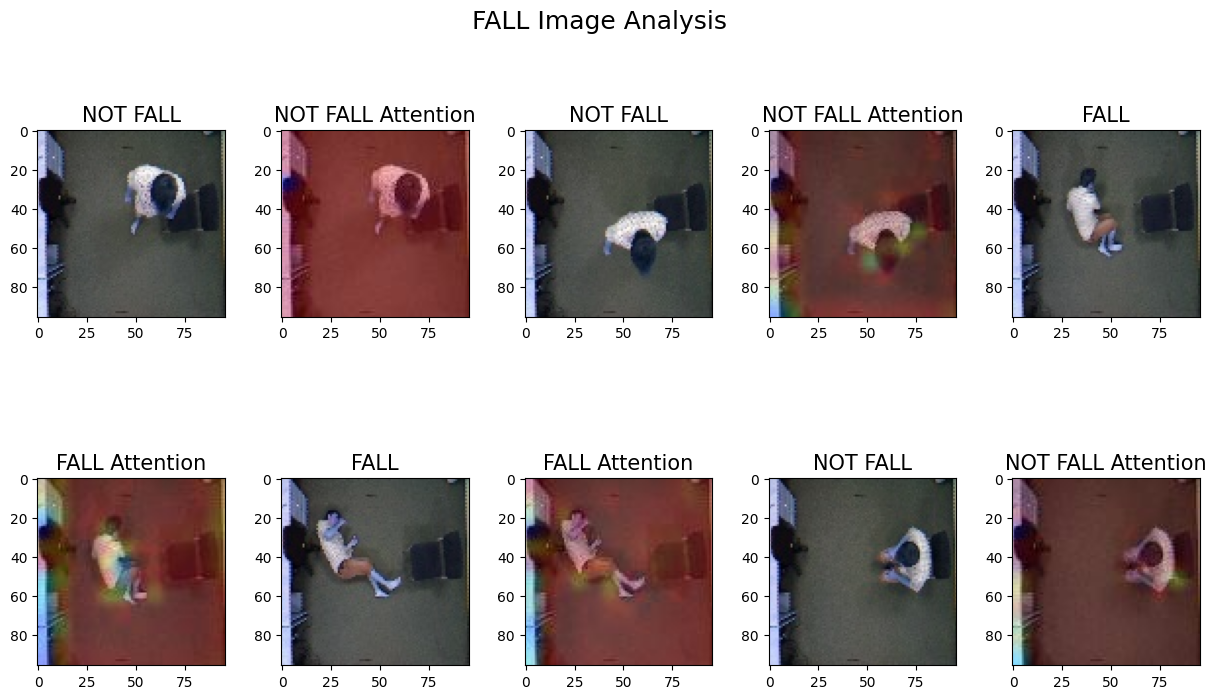

In [72]:
import matplotlib.cm as cm
list_images_sample = ["D:/project/Fall/test_images/fall-03-cam1-rgb-077.jpg",
"D:/project/Fall/test_images/fall-03-cam1-rgb-093.jpg",
"D:/project/Fall/test_images/fall-03-cam1-rgb-178.jpg",
"D:/project/Fall/test_images/fall-03-cam1-rgb-196.jpg",
"D:/project/Fall/test_images/fall-04-cam1-rgb-005.jpg"]

model_builder = keras.applications.xception.Xception
img_size = (96, 96)
preprocess_input = keras.applications.xception.preprocess_input
decode_predictions = keras.applications.xception.decode_predictions
imag = []

last_conv_layer_name = "tf.math.multiply_4"
# To Get Image into numpy array

def get_img_array(img_path, size):
    img = load_img(img_path, target_size = size) 
    array = img_to_array(img) 
    array = np.expand_dims(array, axis = 0)
    return array

# Top create heatmaps for the samples

def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index = None):
    grad_model = tf.keras.models.Model([model.inputs], [model.get_layer(last_conv_layer_name).output, model.output])

    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    grads = tape.gradient(class_channel, last_conv_layer_output)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

# Storing Heatmap values into list

covid_noncovid_heatmap = []

for i in list_images_sample:
    img_array = preprocess_input(get_img_array(i, size = img_size))
    model = model2
    model.layers[-1].activation = None
    preds = model.predict(img_array)
    heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name)
    covid_noncovid_heatmap.append(heatmap)
# To Display GradCAM output for the samples

def save_and_display_gradcam(img_path, heatmap, cam_path = "cam.jpg", alpha = 0.4):
    img = load_img(img_path)
    img = img_to_array(img)

    heatmap = np.uint8(255 * heatmap)

    jet = cm.get_cmap("jet")
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]
    jet_heatmap = array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = img_to_array(jet_heatmap)

    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = array_to_img(superimposed_img)
    superimposed_img.save(cam_path)
    
    imag.append(cv2.imread(img_path))
    imag.append(cv2.imread("./cam.jpg"))


for i in range(len(list_images_sample)):
    save_and_display_gradcam(list_images_sample[i], covid_noncovid_heatmap[i])
    
    
def plot_multiple_img(img_matrix_list, title_list, ncols, main_title = ""):
    
    fig, myaxes = plt.subplots(figsize = (15, 8), nrows = 2, ncols = ncols, squeeze = False)
    fig.suptitle(main_title, fontsize = 18)
    fig.subplots_adjust(wspace = 0.3)
    fig.subplots_adjust(hspace = 0.3)
    
    for i, (img, title) in enumerate(zip(img_matrix_list, title_list)):
        myaxes[i // ncols][i % ncols].imshow(img)
        myaxes[i // ncols][i % ncols].set_title(title, fontsize = 15)
        
    plt.show()
    
    

titles_list = ["NOT FALL","NOT FALL Attention","NOT FALL","NOT FALL Attention","FALL","FALL Attention","FALL","FALL Attention","NOT FALL","NOT FALL Attention"]

plot_multiple_img(imag, titles_list, ncols = 5, main_title = "FALL Image Analysis")